In [21]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5242346938775511 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4609375
FEMALE 0.585 

GLOBAL: 0.5164141414141414 

Using scikit learn accuracy por género en el conjunto to
MALE 0.46228710462287104
FEMALE 0.5748031496062992 

GLOBAL: 0.47979139504563234 

Using scikit learn accuracy por género en el conjunto as
MALE 0.398989898989899
FEMALE 0.5660377358490566 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6888322645363492 	 Validation loss: 0.6872516425989442 	 
  1%|          | 574/57400 [00:04<07:09, 132.17it/s]
Epoch 2 	 Training loss: 0.6845464681499096 	 Validation loss: 0.6853041507429996 	 
  2%|▏         | 1148/57400 [00:09<07:07, 131.46it/s]
Epoch 3 	 Training loss: 0.6828858450522406 	 Validation loss: 0.6848105101262109 	 
  3%|▎         | 1722/57400 [00:14<07:05, 130.94it/s]
Epoch 4 	 Training loss: 0.6822295939673114 	 Validation loss: 0.6845596058894012 	 
  4%|▍         | 2296/57400 [00:19<07:07, 128.81it/s]
Epoch 5 	 Training loss: 0.6818685629226605 	 Validation loss: 0.6842463289277029 	 
  5%|▌         | 2870/57400 [00:23<06:51, 132.61it/s]
Epoch 6 	 Training loss: 0.6817005926723679 	 Validation loss: 0.6844056915428679 	 
  6%|▌         | 3444/57400 [00:28<06:55, 129.87it/s]
Epoch 7 	 Training loss: 0.6816439939085199 	 Validation loss: 0.6844566221964561 	 
  7%|▋         | 4018/57400 [00:33<06:42, 132.48it/s]
Epoch 8 	 Training loss: 0.6

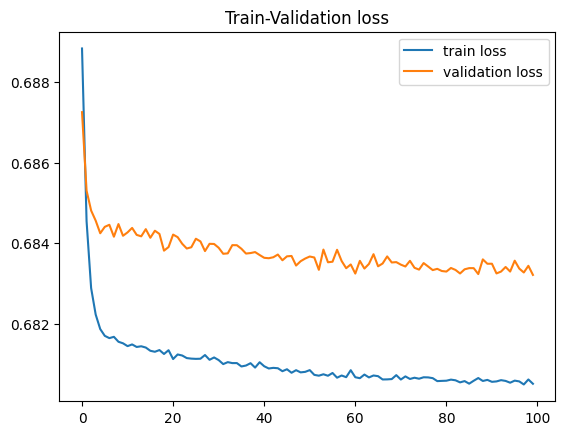

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [20]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [22]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [25]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937204661685 	 Validation loss: 0.691858853323985 	 
  1%|          | 574/57400 [00:06<09:39, 98.14it/s]
Epoch 2 	 Training loss: 0.6933445015643116 	 Validation loss: 0.6919774736388254 	 
  2%|▏         | 1148/57400 [00:12<09:18, 100.70it/s]
Epoch 3 	 Training loss: 0.6932873067540158 	 Validation loss: 0.692337150290861 	 
  3%|▎         | 1722/57400 [00:19<09:11, 100.87it/s]
Epoch 4 	 Training loss: 0.6932573516817458 	 Validation loss: 0.6925496661056907 	 
  4%|▍         | 2296/57400 [00:25<09:09, 100.34it/s]
Epoch 5 	 Training loss: 0.6932352824908931 	 Validation loss: 0.6924956097441205 	 
  5%|▌         | 2870/57400 [00:31<08:54, 102.03it/s]
Epoch 6 	 Training loss: 0.6932428006718798 	 Validation loss: 0.6926871214882803 	 
  6%|▌         | 3444/57400 [00:37<09:08, 98.30it/s]
Epoch 7 	 Training loss: 0.6932589561266351 	 Validation loss: 0.6928443868281478 	 
  7%|▋         | 4018/57400 [00:44<09:16, 96.01it/s]
Epoch 8 	 Training loss: 0.693321242

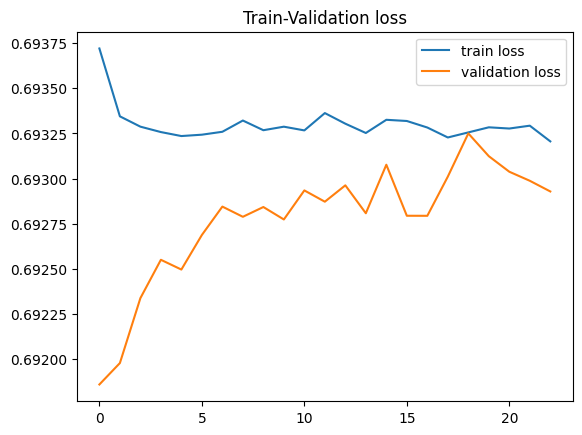

In [26]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5038265306122449 

Using scikit learn accuracy por género en el conjunto about
MALE 0.005208333333333333
FEMALE 0.9825 

GLOBAL: 0.4797979797979798 

Using scikit learn accuracy por género en el conjunto to
MALE 0.004866180048661801
FEMALE 0.9921259842519685 

GLOBAL: 0.4810951760104302 

Using scikit learn accuracy por género en el conjunto as
MALE 0.015151515151515152
FEMALE 0.9784366576819407 



# AS

In [28]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937894899047625 	 Validation loss: 0.6914609337257127 	 
  1%|          | 574/57400 [00:09<14:33, 65.05it/s]
Epoch 2 	 Training loss: 0.6934844883684498 	 Validation loss: 0.692003281439765 	 
  2%|▏         | 1148/57400 [00:19<14:42, 63.71it/s]
Epoch 3 	 Training loss: 0.6934438069523003 	 Validation loss: 0.6924467258534189 	 
  3%|▎         | 1722/57400 [00:29<15:19, 60.56it/s]
Epoch 4 	 Training loss: 0.6933453949070973 	 Validation loss: 0.692626267166461 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<15:17, 60.04it/s]
Epoch 5 	 Training loss: 0.6933029279476259 	 Validation loss: 0.6926310597840002 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:57, 60.76it/s]
Epoch 6 	 Training loss: 0.6933936850534499 	 Validation loss: 0.6929015567747213 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:35, 61.59it/s]
Epoch 7 	 Training loss: 0.6933340144697382 	 Validation loss: 0.6927224185507176 	 

4 

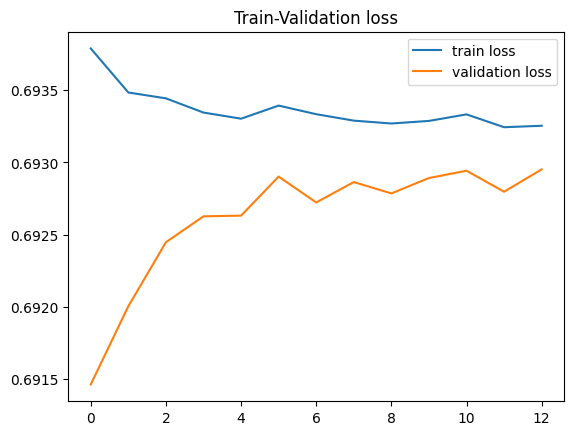

In [29]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5076530612244898 

Using scikit learn accuracy por género en el conjunto about
MALE 0.005208333333333333
FEMALE 0.99 

GLOBAL: 0.4823232323232323 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0072992700729927005
FEMALE 0.994750656167979 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.005050505050505051
FEMALE 0.9946091644204852 



# ADAM

In [31]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808118909493556 	 Validation loss: 0.6800253492290691 	 
  1%|          | 574/57400 [00:07<09:56, 95.21it/s]
Epoch 2 	 Training loss: 0.6688283602950464 	 Validation loss: 0.6583036154003467 	 
  2%|▏         | 1148/57400 [00:13<09:54, 94.57it/s]
Epoch 3 	 Training loss: 0.6534712121461742 	 Validation loss: 0.6460422631037437 	 
  3%|▎         | 1722/57400 [00:19<09:27, 98.04it/s]
Epoch 4 	 Training loss: 0.6459961455665815 	 Validation loss: 0.639681362499625 	 
  4%|▍         | 2296/57400 [00:26<09:28, 96.86it/s]
Epoch 5 	 Training loss: 0.6393096296421742 	 Validation loss: 0.6318458288402881 	 
  5%|▌         | 2870/57400 [00:32<09:14, 98.37it/s]
Epoch 6 	 Training loss: 0.6325915328093937 	 Validation loss: 0.6256961135540978 	 
  6%|▌         | 3444/57400 [00:39<09:34, 93.85it/s]
Epoch 7 	 Training loss: 0.6261561438181674 	 Validation loss: 0.6204872505139496 	 
  7%|▋         | 4018/57400 [00:45<09:23, 94.81it/s]
Epoch 8 	 Training loss: 0.618617137

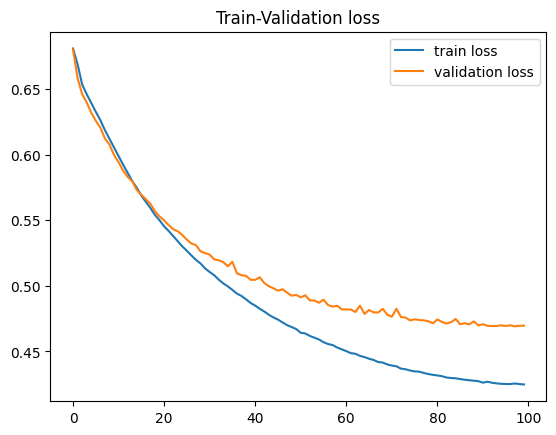

In [32]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7091836734693877 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8489583333333334
FEMALE 0.575 

GLOBAL: 0.5618686868686869 

Using scikit learn accuracy por género en el conjunto to
MALE 0.7274939172749392
FEMALE 0.38320209973753283 

GLOBAL: 0.590612777053455 

Using scikit learn accuracy por género en el conjunto as
MALE 0.7373737373737373
FEMALE 0.4339622641509434 



# TO

In [34]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933959264580797 	 Validation loss: 0.6928219916456837 	 
  1%|          | 574/57400 [00:09<14:56, 63.40it/s]
Epoch 2 	 Training loss: 0.6932008412864565 	 Validation loss: 0.6934557466183678 	 
  2%|▏         | 1148/57400 [00:19<15:05, 62.15it/s]
Epoch 3 	 Training loss: 0.6931643062352303 	 Validation loss: 0.6931650153661179 	 
  3%|▎         | 1722/57400 [00:28<15:28, 59.97it/s]
Epoch 4 	 Training loss: 0.6930040617437728 	 Validation loss: 0.6931411310777826 	 
  4%|▍         | 2296/57400 [00:38<14:04, 65.28it/s]
Epoch 5 	 Training loss: 0.6932665241512272 	 Validation loss: 0.693055790359691 	 
  5%|▌         | 2870/57400 [00:48<15:09, 59.97it/s]
Epoch 6 	 Training loss: 0.6930426781808873 	 Validation loss: 0.6937518412783995 	 
  6%|▌         | 3444/57400 [00:59<13:53, 64.70it/s]
Epoch 7 	 Training loss: 0.693030179585314 	 Validation loss: 0.6934244440773786 	 
  7%|▋         | 4018/57400 [01:08<14:48, 60.10it/s]
Epoch 8 	 Training loss: 0.6929446578

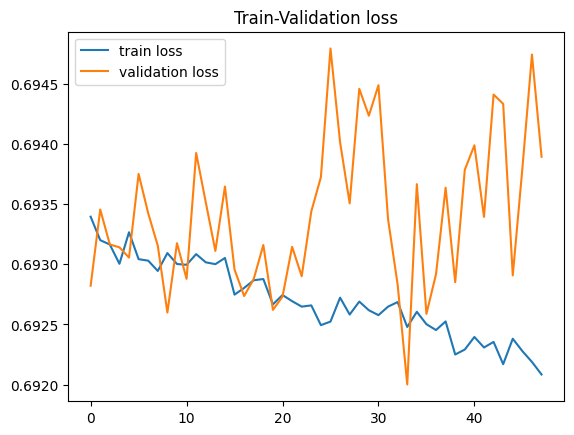

In [35]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [36]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5025510204081632 

Using scikit learn accuracy por género en el conjunto about
MALE 0.12760416666666666
FEMALE 0.8625 

GLOBAL: 0.48484848484848486 

Using scikit learn accuracy por género en el conjunto to
MALE 0.10462287104622871
FEMALE 0.89501312335958 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.07575757575757576
FEMALE 0.921832884097035 



# AS

In [37]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693354372155791 	 Validation loss: 0.6931579557515807 	 
  1%|          | 574/57400 [00:09<14:13, 66.57it/s]
Epoch 2 	 Training loss: 0.6931047154012873 	 Validation loss: 0.6938901907306606 	 
  2%|▏         | 1148/57400 [00:18<14:43, 63.69it/s]
Epoch 3 	 Training loss: 0.6932292363577188 	 Validation loss: 0.6930811142517348 	 
  3%|▎         | 1722/57400 [00:28<13:05, 70.85it/s]
Epoch 4 	 Training loss: 0.6931894253355285 	 Validation loss: 0.6934753656387329 	 
  4%|▍         | 2296/57400 [00:37<15:00, 61.22it/s]
Epoch 5 	 Training loss: 0.6931659123415731 	 Validation loss: 0.6930479417412968 	 
  5%|▌         | 2870/57400 [00:47<13:50, 65.68it/s]
Epoch 6 	 Training loss: 0.693012003803087 	 Validation loss: 0.6933009786120916 	 
  6%|▌         | 3444/57400 [00:56<14:56, 60.21it/s]
Epoch 7 	 Training loss: 0.6931217081247721 	 Validation loss: 0.6922709850941674 	 
  7%|▋         | 4018/57400 [01:06<13:56, 63.81it/s]
Epoch 8 	 Training loss: 0.6929416715

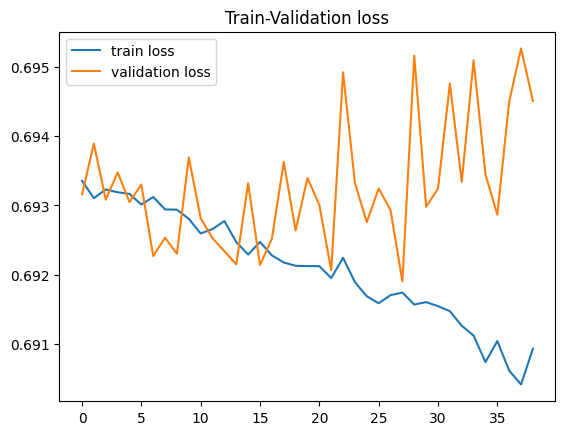

In [38]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [39]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4770408163265306 

Using scikit learn accuracy por género en el conjunto about
MALE 0.5234375
FEMALE 0.4325 

GLOBAL: 0.4898989898989899 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6131386861313869
FEMALE 0.3569553805774278 

GLOBAL: 0.5058670143415906 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6590909090909091
FEMALE 0.3423180592991914 

